# Open Traffic Reporter: Map-Matching Validation

## 0. Setup Test Environment

#### Import packages

In [2]:
from __future__ import division
from matplotlib import pyplot as plt
from matplotlib import cm, colors, patheffects
import numpy as np
import os
import glob
import urllib
import json
import pandas as pd
from random import shuffle, choice
import pickle
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val
%matplotlib inline

#### Define user vars

In [3]:
mapzenKey = os.environ.get('MAPZEN_API')
gmapsKey = os.environ.get('GOOGLE_MAPS')
cityName = 'San Francisco'

## 1. Generate Random Routes

#### Using Mapzen Venues (requires good WOF coverage):

In [4]:
routeList = val.get_routes_by_length(cityName, minRouteLength=1, maxRouteLength=5, numResults=100, apiKey=mapzenKey)

#### Using Google Maps POIs (better for non-Western capitals):

In [4]:
# routeList = val.get_POI_routes_by_length(cityName, 1, 5, 10, gmapsKey)

#### Or load a specific set of routes you've already saved

In [20]:
routeList = pickle.load(open('{0}_100_routes.pkl'.format('San Francisco'),'rb'))

#### Optionally save route list for future use

In [9]:
pickle.dump(routeList, open('{0}_10_routes.pkl'.format(cityName),'wb'))

## 2. Iterate Through Routes and Score the Matches

#### Define the noise levels and sample rates used to generate synthetic GPS traces

In [4]:
noiseLevels = np.linspace(0, 100, 21)    # in meters
sampleRates = [1, 5, 10, 20, 30]    # in seconds

In [5]:
matchDf, speedDf = val.get_route_metrics(routeList, sampleRates, noiseLevels, saveResults=False)

#### Save output

The previous step will typically take a long time to run if you are generating a lot of routes (> 10), so it's a good idea to save your dataframes for later use.

In [9]:
# matchDf.to_csv('sf_100_matches.csv', index=False)
# speedDf.to_csv('sf_100_speeds.csv', index=False)

#### Load prior output if you have any

In [7]:
matchDf = pd.read_csv('sf_100_matches.csv')
speedDf = pd.read_csv('sf_100_speeds.csv')

### Check for Pattern Failure 

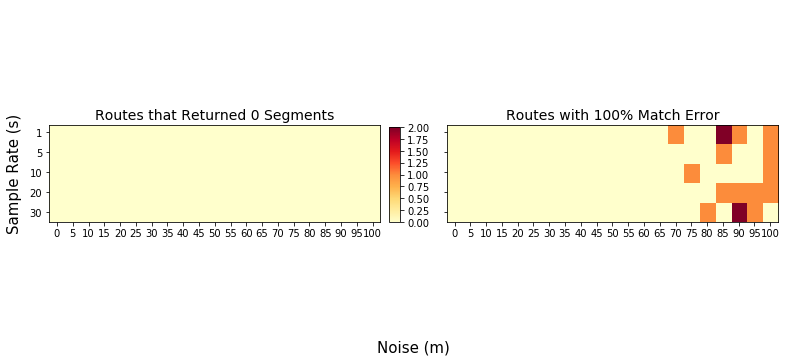

In [5]:
val.plot_pattern_failure(matchDf, sampleRates, noiseLevels)

## 3. Visualize the Scores

### Distance-based Metrics

##### A measure of distance-based map matching error borrowed from [Newton and Krumm (2009)](http://research.microsoft.com/en-us/um/people/jckrumm/Publications%202009/map%20matching%20ACM%20GIS%20camera%20ready.pdf):

<img src="krumm_newson_dist.png" alt="Drawing" style="width: 400px;" align="center"/>

Plots in the left column below represent match scores based solely on segment ID, where "undermatches" denote the percentage of segments in the original route not identified during map matching (false negatives), and "overmatches" refer to segments identified during map matching that were not a part of the original route (false positives). The right-hand column shows the same metrics as the left, but weighted by segment length as a percentage of the total route trace. In other words, for the distance-weighted metrics, a mismatched segment 2 km in length penalizes the match score by twice as much as a 1 km segment. 

For reference, the graph on the top right ("distance traveled") corresponds to Newton and Krumm's (2009) metric as depicted in the image above. We will return to this metric later for use in optimizing the map-matching algorithm.

This function plots the median error rate for each sample rate/noise level pair. Thus, the more routes that you've aggregated, the smoother your curves will be.

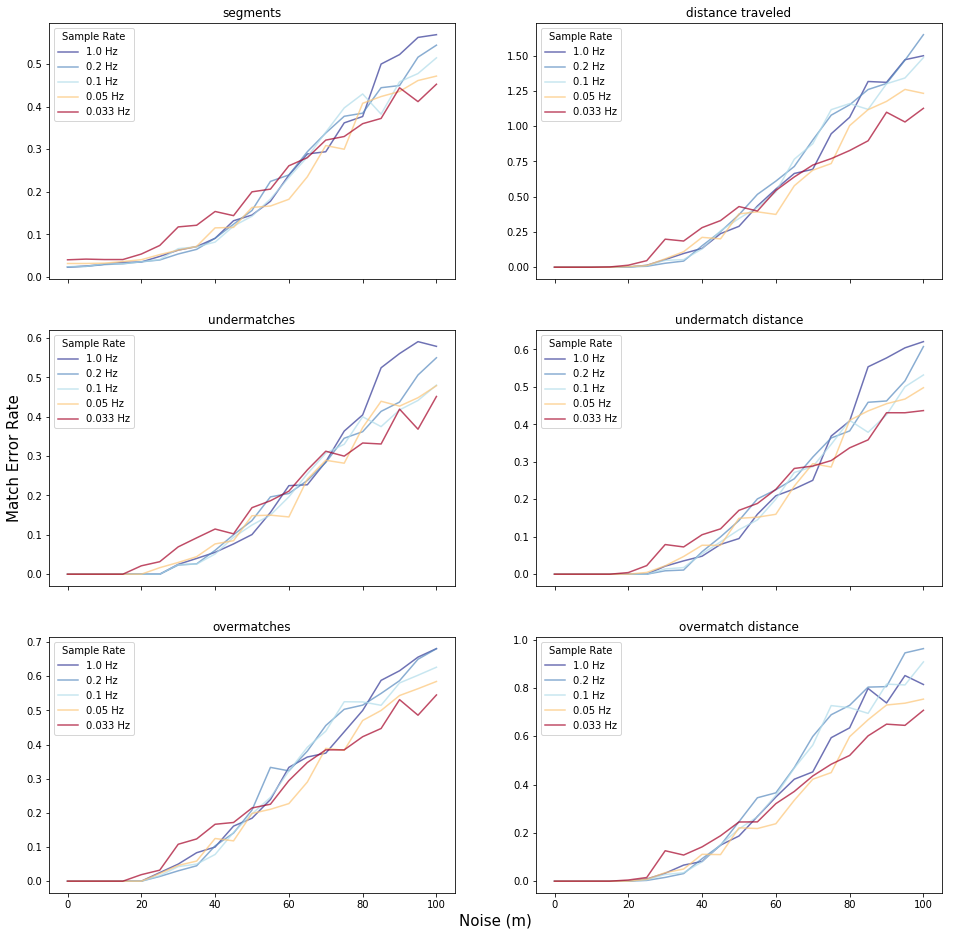

In [7]:
val.plot_distance_metrics(matchDf, sampleRates)

Worth noting are the very consistent points of inflection about which error for low sample rate GPS traces (red) improves relative to that of higher sample rate measurements (blue). The inflection point occurs at ~70 m of noise across almost all of our metrics, and is consistent with the findings of Newton and Krumm (2009). These results suggest that lower sample rates tend to be more robust against mismatch error at higher levels of noise (> 60 m).

## 4. Optimize Map-Matching Parameters

The Open Traffic Reporter map-matching service is based on the Hidden Markov Model (HMM) design of [Newton and Krumm (2009)](http://research.microsoft.com/en-us/um/people/jckrumm/Publications%202009/map%20matching%20ACM%20GIS%20camera%20ready.pdf). Skipping over 99% of the innerworkings of HMMs, there are two probability-related parameters in the HMM algorithm that should be estimated from data (for more detail see [here](https://en.wikipedia.org/wiki/Hidden_Markov_model)):

## $\sigma_z$

The first parameter that needs tuning is $\sigma_z$. It appears in the equation below which expresses the probability of recording the GPS measurement $z_t$ from road segment $r_i$, where $x_{t,i}$ is the point on road segment $r_i$ nearest the measurement $z_t$. 

### $$ p(z_t|r_i) = \frac{1}{\sqrt{2 \pi \sigma_z}} e^{-0.5(\frac{||z_t - x_{t,i}||_{\text{great circle}}}{\sigma_z})^2}$$

In practice, $\sigma_z$ can be thought of as an estimate of the standard deviation of the GPS noise. The more we trust our measurements, the lower our $\sigma_z$ should be. Newton and Krumm (2009) derive their value of $\sigma_z$ from the median absolute deviation over their dataset, arriving at a value of 4.07 m. 

## $\beta$

The second estimated parameter, $\beta$, comes from the exponential distribution. Newton and Krumm found that the distribution of differences between "great circle" distances (also known as "as-the-crow-flies" distance) and map-matched route distance traveled closely resembles that of an exponential probability distribution: 

### $$p(d_t) = \frac{1}{\beta}e^{\frac{-d_t}{\beta}} $$

where $d_t$ is the difference between the great circle distance and route distance traveled between time $t$ and $t+1$, and $\beta$ is the "scale" parameter (or inverse rate) of the exponential distribution. In this context, $\beta$ can be thought of as the expected difference between great circle distances and route distance traveled. Newton and Krumm use a different robust estimator taken from statistics literature to estimate this value from data.

### Grid search to find optimal parameter values

An alternative to explicitly estimating these values from data is search the feasible parameter space and store the values that result in the optimal match scores. This is a common approach for algorithm optimization, typically referred to as a grid search or parameter sweep. Here, we perform a grid search for each of our specified sample rates so that we can store the optimal parameter values for each one.

Note: because GPS noise cannot be controlled in a top down way (as opposed to sample rate), our parameter values for a given sample rate will be optimized over the entire range of noise: 0 to 100 m.

#### Define search space

Because this grid search is in such a high dimensional space ($\text{noise levels} \times \text{sample rates} \times \beta \ \text{values} \times \sigma\  \text{values} \times \text{number of routes}$), it is recommended to use a smaller number of discrete noise levels for the section of the analysis (< 10).

In [19]:
noiseLevels = np.linspace(0, 100, 6)   # in meters
sampleRates = [1, 5, 10, 20, 30]   # in seconds
betas = np.arange(0.5, 10.5, 0.5)   # no units
sigmaZs = np.arange(0.5, 10.5, 0.5)    #no units

#### Search and score

In [3]:
val.grid_search_hmm_params(cityName, routeList, sampleRates, noiseLevels, betas, sigmaZs)

#### Visualize results

In [17]:
# glob all the route data together
path ='../data'
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
frame = pd.concat(list_)

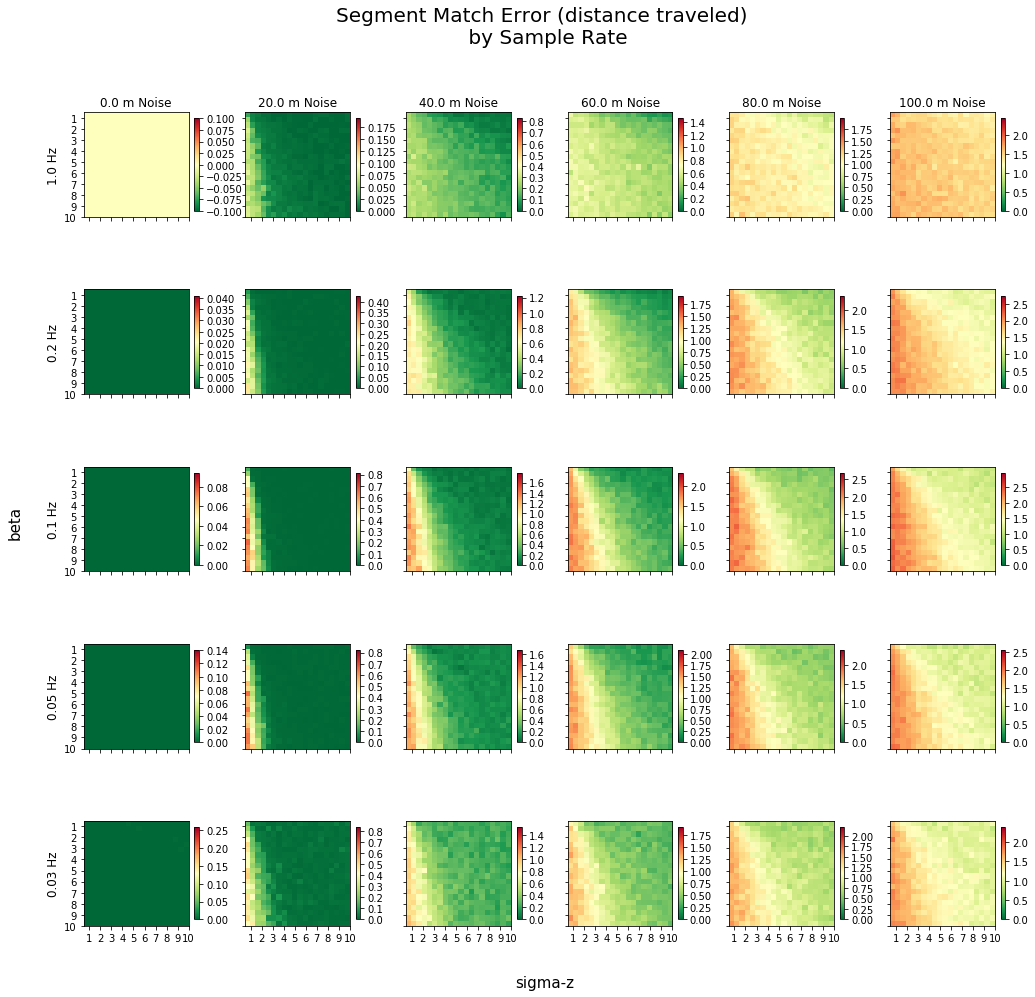

In [20]:
paramDict = val.plot_param_scores(frame, sampleRates, noiseLevels, betas, sigmaZs)

Although there is clearly no one set of optimal parameter values, the results suggest that the default $\sigma_z$ of 4.07 is probably close to optimal, while the default $\beta$ value of 3 is almost certainly too low for a city as dense as San Francisco.

Rather than average the optimal parameter values across sample rate and noise level, which would severely impact the performance of high-noise GPS measurements, it is more useful to use the above results to make an informed decision about what level of GPS accuracy to prioritize for.

For example, at noise levels below 40 m and sample rates above 0.1 Hz, clearly any $\beta$ value above 2 will optimize the performance of the algorithm. Therefore, even if a given provider expects most of their measurements to be within this range, it would be more beneficial to choose parameter values that will optimize performance for noisier data, as long as $\beta$ remains $> 2$.

Conversely, it would not be wise to tune the parameters to optimize the performance at high levels of noise without any such constraints. There is only so much we can expect the algorithm to do with measurements that have less than 80 m of accuracy in a region where city blocks are significantly less than that distance in length, for example. 

#### Geographic Classification based on Expected Positional Accuracy

One method that accounts the wide range of expected GPS accuracies for a given region while avoids overfitting to any  one data type would involved defining regions of expected GPS accuracy _a priori_ for a given metro area. This could be as simple as an urban/suburban/rural classification, whose thresholds could reasonably be learned from data. The HMM parameters could then be dynamically set based on the region from within which any given measurement was taken.

For now, we will take the optimal param values for a reasonable expectation of data quality:

#### Store optimal params

In [21]:
beta, sigmaZ = val.get_optimal_params(paramDict, sampleRateStr='10', noiseLevelStr='40')

## 5. Generate Testing Data

Now that we've found some optimal parameter settings, we can generate another set of fake routes and matching scores:

In [31]:
testRouteList = val.get_routes_by_length(cityName, 1, 5, 20, mapzenKey)

In [32]:
noiseLevels = np.linspace(0, 100, 21)    # in meters
sampleRates = [1, 5, 10, 20, 30]    # in seconds

In [33]:
matchDf, speedDf = val.get_route_metrics(
    testRouteList, sampleRates, noiseLevels, sigmaZ=sigmaZ, beta=beta, saveResults=False)

Route: 0 // Noise Level: 0.0 // Sample Rate: 1
Route: 0 // Noise Level: 0.0 // Sample Rate: 5
Route: 0 // Noise Level: 0.0 // Sample Rate: 10
Route: 0 // Noise Level: 0.0 // Sample Rate: 20
Route: 0 // Noise Level: 0.0 // Sample Rate: 30
Route: 0 // Noise Level: 5.0 // Sample Rate: 1
Route: 0 // Noise Level: 5.0 // Sample Rate: 5
Route: 0 // Noise Level: 5.0 // Sample Rate: 10
Route: 0 // Noise Level: 5.0 // Sample Rate: 20
Route: 0 // Noise Level: 5.0 // Sample Rate: 30
Route: 0 // Noise Level: 10.0 // Sample Rate: 1
Route: 0 // Noise Level: 10.0 // Sample Rate: 5
Route: 0 // Noise Level: 10.0 // Sample Rate: 10
Route: 0 // Noise Level: 10.0 // Sample Rate: 20
Route: 0 // Noise Level: 10.0 // Sample Rate: 30
Route: 0 // Noise Level: 15.0 // Sample Rate: 1
Route: 0 // Noise Level: 15.0 // Sample Rate: 5
Route: 0 // Noise Level: 15.0 // Sample Rate: 10
Route: 0 // Noise Level: 15.0 // Sample Rate: 20
Route: 0 // Noise Level: 15.0 // Sample Rate: 30
Route: 0 // Noise Level: 20.0 // Sampl

The change in scores won't look that much different to the naked eye, but we can feel more confident that we've chosen our algorithm parameters in an intelligent way that best fits our data and the region from which that data was collected. We also now have a reliable way for replicating this process across different metropolitan regions and for different data qualities.

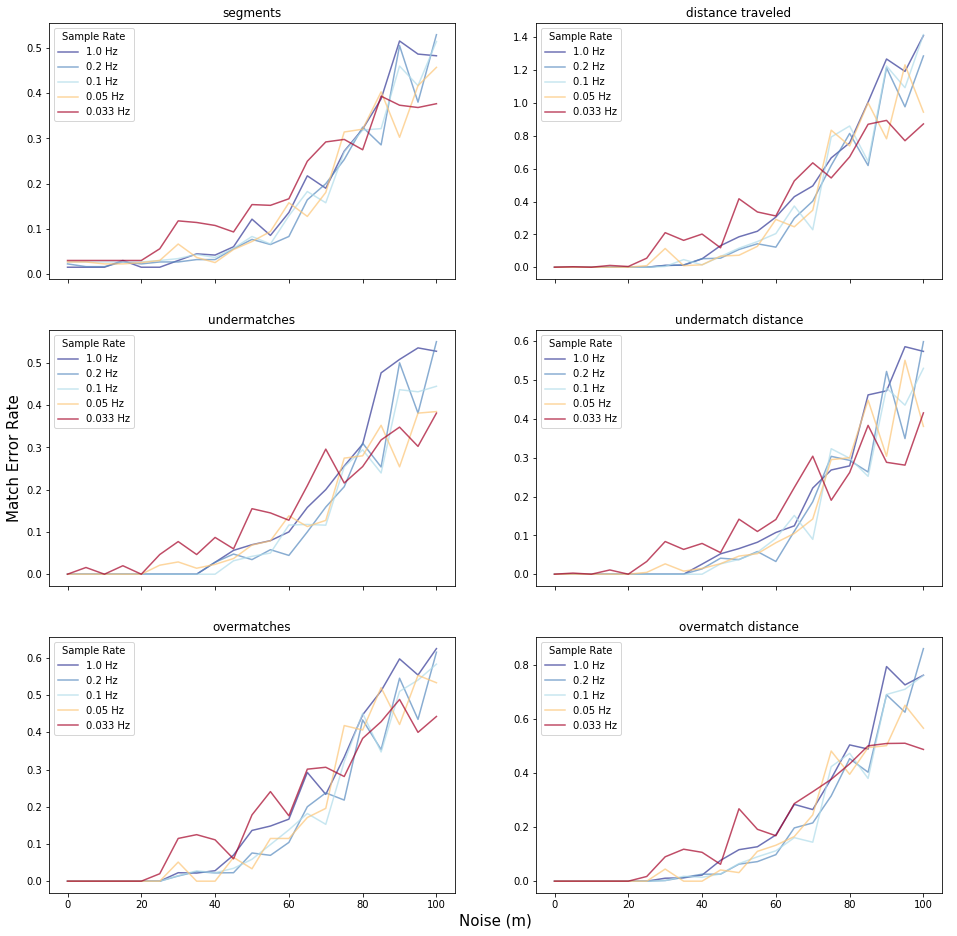

In [34]:
val.plot_distance_metrics(matchDf, sampleRates)

## 6. Post-processing with Speed-based Metrics

Mapzen's map-matching algorithm relies on a kind of graphical model known as a Hidden Markov Model (HMM). Because HMM's are probabilistic in nature, the match returned by the algorithm will always be a best guess. However, this best guess may still be far from the "truth". Thus, we would like some method for filtering out match results that just aren't realistic. 

Derived segment speeds provide us with one such method for throwing out bad results. Although GPS positional data is often very noisy, its temporal measurements are rarely wrong. Comparing the time (speed) it takes for an agent to traverse a segment to the known speed limit along that segment can provide a very accurate way to filter out erroneous matches.

Below, we attempt to learn from our simulated GPS traces what an optimal speed-error threshold might be for creating such a filter.

#### Calculate and plot the optimal speed error threshold

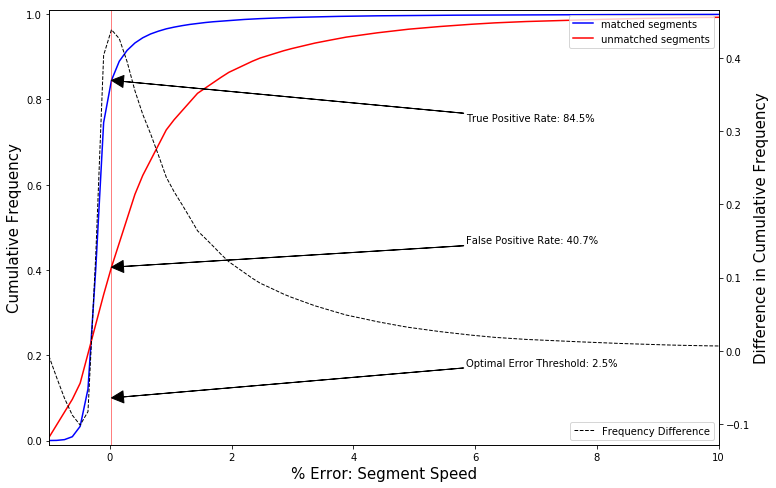

In [8]:
speedErrorThreshold = val.get_optimal_speed_error_threshold(speedDf, plot=True)

#### Map Matching Accuracy Using One-Size-Fits-All Speed Error Threshold

Statistical accuracy measures the fraction of samples correctly identified as either true positives or true negatives, or in our case, matches and misses, respectively.

$$ \text{Accuracy} = \frac{\text{True Positives} \ + \ \text{True Negatives}}{\text{Total Population}} =  \frac{\text{# Matches Kept} \ + \ \text{# Misses Discarded}}{\text{# Segments}}$$

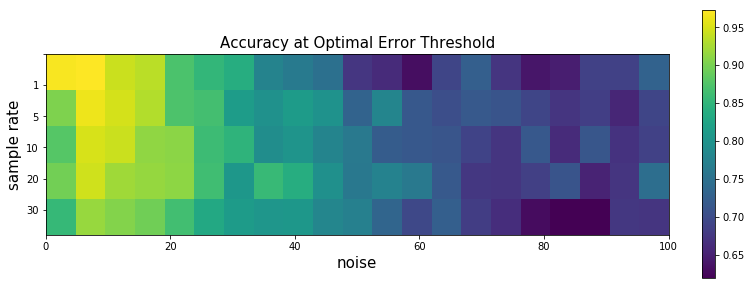

In [36]:
oneSizeFitsAll = val.plot_accuracy_heatmap(speedDf, [speedErrorThreshold], sampleRates, noiseLevels)

#### Calculate optimal thresholds for each sample rate

GPS sample rate is likely to be fixed for a given data provider. We can thus tune our cutoff threshold based on the sample rate which should improve the accuracy of our matches overall.

In [23]:
thresholdRateDict = {}
thresholdsByRate = []
for r, rate in enumerate(sampleRates):
    df = speedDf[speedDf['sample_rate'] == rate]
    threshold = val.get_optimal_speed_error_threshold(df, plot=False, saveFig=False)
    thresholdsByRate.append(threshold)
    thresholdRateDict[str(int(sampleRates[r]))] = threshold

In [24]:
thresholdRateDict

{'1': -0.042885907591220018,
 '10': 0.12259286172616979,
 '20': 0.099837274612300186,
 '30': 0.071563534379066596,
 '5': 0.086051105279773443}

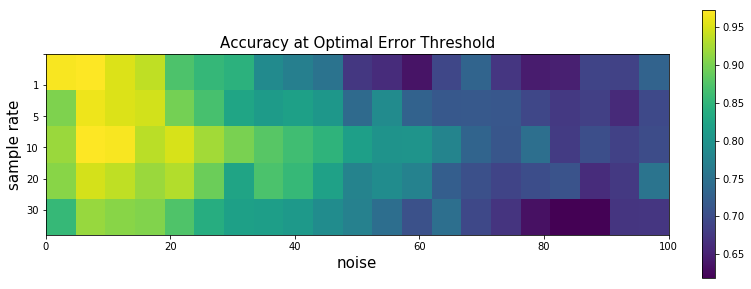

In [39]:
accBySampleRate = val.plot_accuracy_heatmap(speedDf, thresholdsByRate, sampleRates, noiseLevels)

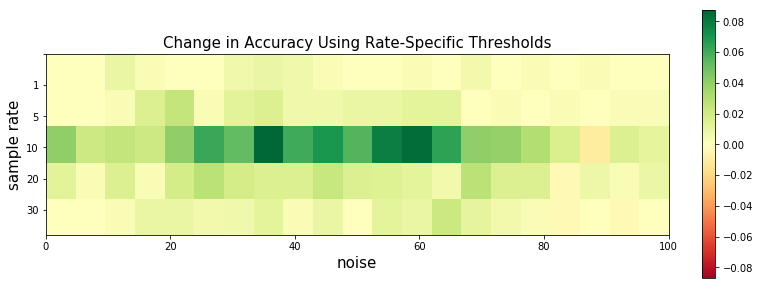

In [40]:
val.plot_change_in_acc(oneSizeFitsAll, accBySampleRate, sampleRates, noiseLevels)

Prior knowledge of expected GPS sample rate can result in accuracy gains of up to 8% using the optimal speed error threshold.

#### Geographic Classification

Similar to the parameter optimzation, choosing speed error thresholds is another area of map-matching that would significantly benefit from the creation of designated metro regions based on expected GPS accuracy.

#### Weighted penalty function

We need not default to the "optimal" speed error threshold, which treats false positives and false negatives as equally "bad". For example, if a given customer/data provider cares more about mistakenly including bad data (Type I error) than missing good data (Type II error) a more conservative threshold can be set below this optimal value. The CDF plots above allow an analyst to visually inspect the impact that such discretionary adjustments will have on the outcome. This can also be performed in a programmatic fashion by assigning differential weights to our two types of error and thus shifting the optimal value itself.

## 7. Visualize Speed-Based Filtering

#### Get more routes

In [25]:
vizRoutes = val.get_routes_by_length(cityName, 1, 5, 10, mapzenKey)

#### Synthesize the GPS traces and apply our learned parameters and thresholds

In [29]:
noiseLevels = np.linspace(0, 100, 21)
noiseLevels = [50]
sampleRates = [1, 5, 10, 20, 30]
sampleRates = [10]

In [31]:
matchDf, speedDf = val.get_route_metrics(
    vizRoutes, sampleRates, noiseLevels, sigmaZ=sigmaZ, beta=beta,
    speedErrThreshold=thresholdRateDict[str(sampleRates[0])])

Route: 0 // Noise Level: 50.0 // Sample Rate: 10
Route: 1 // Noise Level: 50.0 // Sample Rate: 10
Route: 2 // Noise Level: 50.0 // Sample Rate: 10
Route: 3 // Noise Level: 50.0 // Sample Rate: 10
Route: 4 // Noise Level: 50.0 // Sample Rate: 10
Route: 5 // Noise Level: 50.0 // Sample Rate: 10
Route: 6 // Noise Level: 50.0 // Sample Rate: 10
Route: 7 // Noise Level: 50.0 // Sample Rate: 10
Route: 8 // Noise Level: 50.0 // Sample Rate: 10
Route: 9 // Noise Level: 50.0 // Sample Rate: 10


By defining our speed error threshold as a map matching setting, we can visually inspect the map-matching process that we have defined based on the parameters and thresholds we've derived above. We can style the output of our sample routes in order to highlight the segments and their speeds that will either make their way into the datastore or get thrown out. This is simply a way of visualizing the process that in practice would occur dynamically, and entirely behind-the-scenes. 

In the maps below, the original route used to generate the fake GPS measurements are shown in **<span style="color:orange">orange</span>**, along with the points along these routes that were resampled at the specified sample rate. The perturbed points that constitute the synthetic GPS measurements themselves are shown in **<span style="color:blue">blue</span>**, along with the matched route that was based on the fake GPS data. Segments along this matched route are colored differentially based on the specified speed error threshold. Segments that exceeded the threshold are shown in ** <span style="color:red">red</span>**, while segments that did not exceed the threshold are shown in  **<span style="color:green">green</span>**. Segments for whom a consistent match could not be found are shown in  **<span style="color:yellow">yellow</span>**.

Run the following cell as many times as you like to select a random route from among those you just simulated, and view it on a map: 

In [32]:
geojsonList = [trace for trace in os
               .listdir('../data/') if trace.endswith('json')]
fname = '../data/' + choice(geojsonList)
val.generate_route_map(fname, 14)

## 8. Interregional Comparisons

Apart setting the sample rate of GPS collection, tuning the map-matching parameters, and imparting some domain knowledge about automobile speeds, there are certain factors beyond our control that will heavily influence the performance of the algorithm. The single most important of these is the built environment. Things like road network density and building height can severely impact the reliability of the HMM predictions, as well as the GPS measurements upon which they depend.

It is thus worthwhile to compare the performance across regions. In practice, the algorithm parameters and post-processing thresholds can be customized to match the character of a given region. And some regions can reasonably expect better or worse performance of map-matching along these lines. This is one reason why it is so important to be able to make an informed decision about how to weight the importance of Type I error vs Type II error.

For the purposes of this demonstration, however, we will simply compare the performance of what we've already seen in San Francisco, a city of relatively high road network density, to another, more suburban locale in the United Sates: Prescott, AZ.

#### San Francisco, CA vs. Prescott, AZ

In [ ]:
cityName = 'Prescott, AZ'
routeList = val.get_routes_by_length(cityName, 1, 5, 20, mapzenKey)

In [ ]:
noiseLevels = np.linspace(0, 100, 21)
sampleRates = [1, 5, 10, 20, 30]
azMatchDf, azSpeedDf = val.get_route_metrics(routeList, sampleRates, noiseLevels, saveResults=False)

Route: 0 // Noise Level: 0.0 // Sample Rate: 1
Route: 0 // Noise Level: 0.0 // Sample Rate: 5
Route: 0 // Noise Level: 0.0 // Sample Rate: 10
Route: 0 // Noise Level: 0.0 // Sample Rate: 20
Route: 0 // Noise Level: 0.0 // Sample Rate: 30
Route: 0 // Noise Level: 5.0 // Sample Rate: 1
Route: 0 // Noise Level: 5.0 // Sample Rate: 5
Route: 0 // Noise Level: 5.0 // Sample Rate: 10
Route: 0 // Noise Level: 5.0 // Sample Rate: 20
Route: 0 // Noise Level: 5.0 // Sample Rate: 30
Route: 0 // Noise Level: 10.0 // Sample Rate: 1
Route: 0 // Noise Level: 10.0 // Sample Rate: 5
Route: 0 // Noise Level: 10.0 // Sample Rate: 10
Route: 0 // Noise Level: 10.0 // Sample Rate: 20
Route: 0 // Noise Level: 10.0 // Sample Rate: 30
Route: 0 // Noise Level: 15.0 // Sample Rate: 1
Route: 0 // Noise Level: 15.0 // Sample Rate: 5
Route: 0 // Noise Level: 15.0 // Sample Rate: 10
Route: 0 // Noise Level: 15.0 // Sample Rate: 20
Route: 0 // Noise Level: 15.0 // Sample Rate: 30
Route: 0 // Noise Level: 20.0 // Sampl

In [5]:
sfMatchDf = pd.read_csv('sf_100_matches.csv')

In [12]:
sfMedianScores = sfMatchDf[['noise','sample_rate','distance traveled']].groupby(['noise','sample_rate']).agg('median').reset_index()
azMedianScores = azMatchDf[['noise','sample_rate','distance traveled']].groupby(['noise','sample_rate']).agg('median').reset_index()

In [13]:
merged = pd.merge(sfMedianScores, azMedianScores, on=['noise','sample_rate'], suffixes=('_sf','_az'))
merged['diff'] = merged['distance traveled_sf'] - merged['distance traveled_az']

In [ ]:
sfDens = sfMatchDf['avg_density'].median()
azDens = azMatchDf['avg_density'].median()

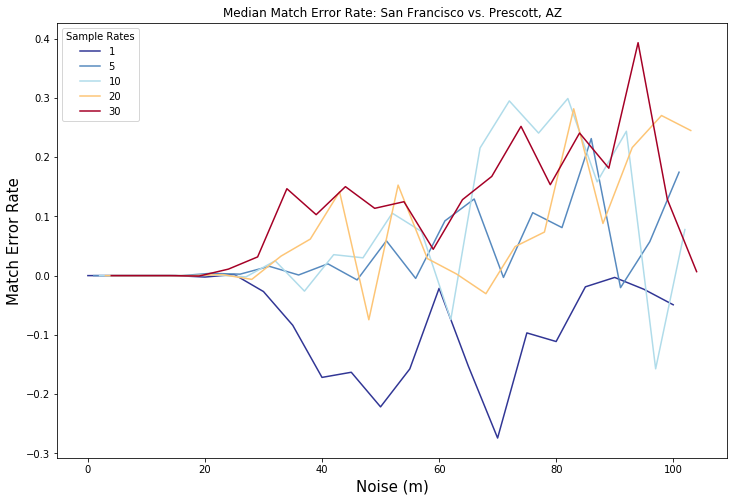

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
norm = plt.Normalize()
cmap = plt.get_cmap('RdYlBu_r')
colors = cmap(norm(sampleRates))
for r, rate in enumerate(sampleRates):
    ax.plot(merged.loc[merged['sample_rate'] == rate, 'diff'], label=rate, color=colors[r])
ax.set_xlabel('Noise (m)', fontsize=15)
ax.set_ylabel('Match Error Rate', fontsize=15)
ax.set_title('Median Error Rate Difference: San Francisco () vs. Prescott, AZ')
ax.legend(title='Sample Rates')